In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [2]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
device

device(type='cpu')

# Import Data

In [3]:
df = pd.read_csv("data/daily_min_temp.csv", parse_dates=['Date'])
df['quarter'] = df.Date.dt.quarter
df = pd.get_dummies(df, columns=['quarter'])
df.set_index('Date', inplace=True)
df.head()

,Temp,quarter_1,quarter_2,quarter_3,quarter_4
Date,,,,,
1981-01-01,20.7,1,0,0,0
1981-01-02,17.9,1,0,0,0
1981-01-03,18.8,1,0,0,0
1981-01-04,14.6,1,0,0,0
1981-01-05,15.8,1,0,0,0


## Scaling membantu RNN

In [4]:
#jika rata2 standard deviasi tidak berubah boleh pakai  ini rata2 nya konstan tidak selalu boleh digunakan, pakai sklearn
# df.Temp = df.Temp.transform(lambda x: (x - x.mean()) / x.std())

<AxesSubplot:xlabel='Date'>

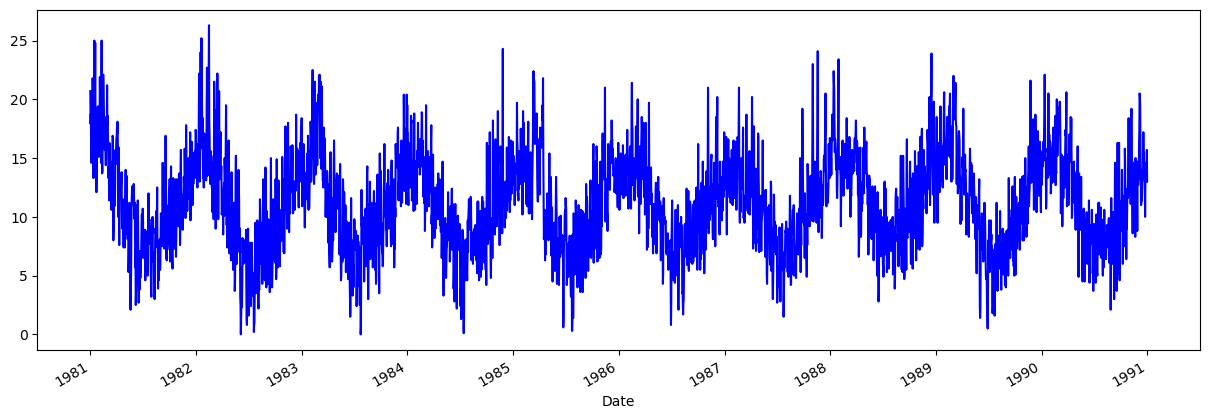

In [5]:
df.Temp.plot(figsize=(15, 5), color='b')

Note: data harian banyak noise nya karena jika memaka time yang lebih kecil contoh harian, menit, jam datanya jadi noisy sehingga jadi susah prediksinya. bisa saja tapi pakai rnn tapi lebih baik time yang lebih besar mingguan, bulanan

Jika pakai data lebih besar maka lakukan resampling

# Dataset Splitting

Dataset time series jangan di shuffle 

In [6]:
ts_train, ts_test = train_test_split(df, test_size=0.2, shuffle=False)
ts_train.shape, ts_test.shape

((2920, 5), (730, 5))

# Dataset & Data loader

Note:
* kalau pakai data multilabel pakai multilabeldataset
* kalau multi class pakai image class
* kalau tabular kita pakai tensor dataset
* kalau timeseries di jcopdl pakai timeseriesDataset

In [7]:
from torch.utils.data import TensorDataset, DataLoader
from jcopdl.utils.dataloader import TimeSeriesDataset

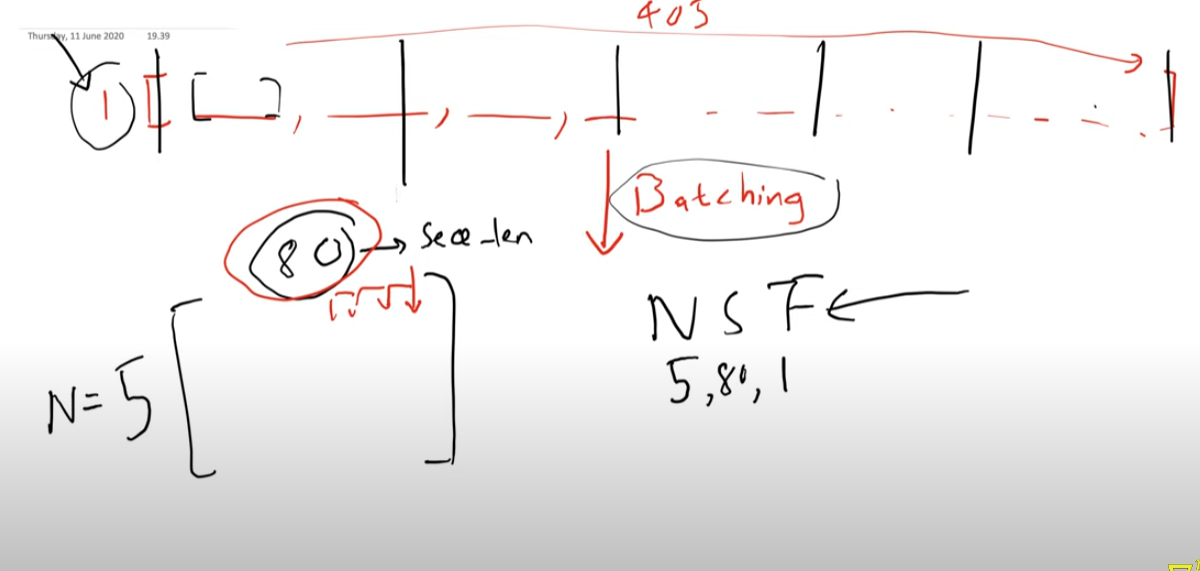

In [8]:
# seq_len = 6 # 6 minggu
# seq_len = 16 #16 minggu = 4 bulan
# seq_len = 14 # artinya Backpropagation Throught Time sampai 14 hari ke belakang
seq_len = 5 
# bs = 16
bs = 32

train_set = TimeSeriesDataset(ts_train, "Temp", seq_len)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=False)

test_set = TimeSeriesDataset(ts_test, "Temp", seq_len)
testloader = DataLoader(test_set, batch_size=bs, shuffle=False)

(N, S, F): (583, 5, 5)
Note: last 4 data excluded

(N, S, F): (145, 5, 5)
Note: last 4 data excluded



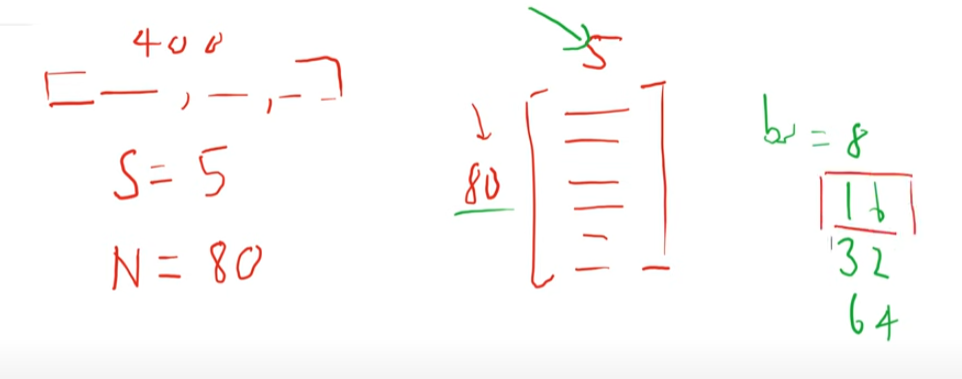

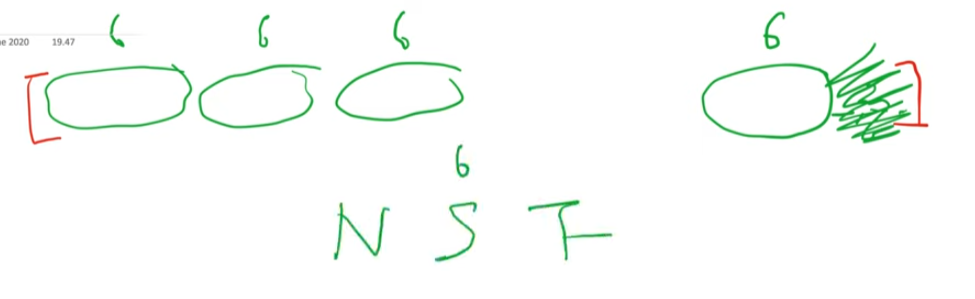

excluded maksudnya data dibuang atau diabaikan

# Arsitektur & Config

In [9]:
from jcopdl.layers import linear_block

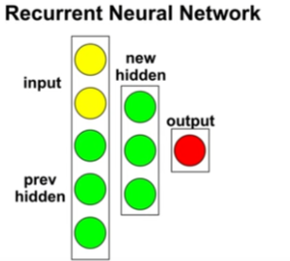

* layer pertama dan kedua itu sudah dibungkus oleh Pytorch next nya tinggal kombinasi linear ke output

In [10]:
class GRU(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers, dropout):
        super().__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size ,output_size)
        
    def forward(self, x, hidden):
        x, hidden = self.gru(x, hidden)
        x = self.fc(x)
        return x, hidden

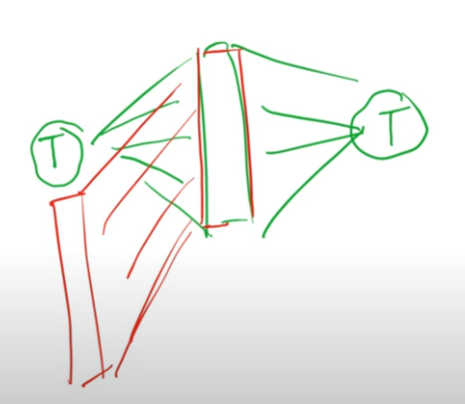

In [11]:
train_set.n_feature

5

In [12]:
config = set_config({
    "input_size": train_set.n_feature,
    "output_size": 1,
    "hidden_size": 64,
    "num_layers": 2, 
    "dropout": 0,
    "seq_len": train_set.n_seq
})

# Training Preparation -> MCOC

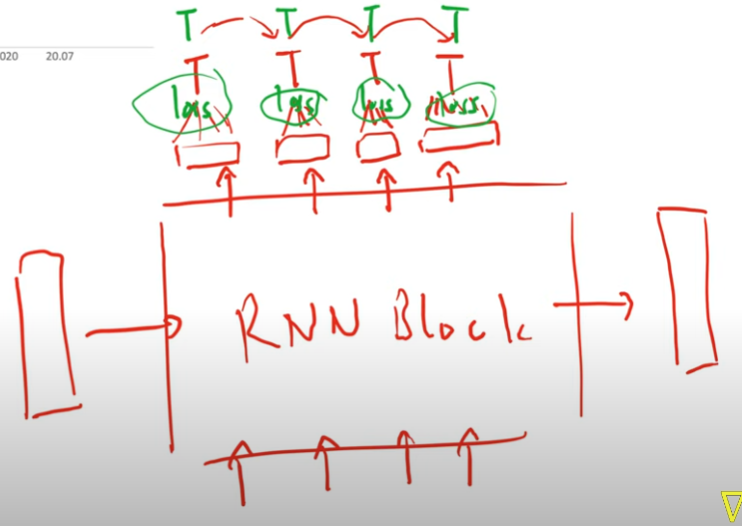

In [13]:
model = GRU(config.input_size, config.output_size, config.hidden_size, config.num_layers, config.dropout).to(device)
criterion = nn.MSELoss(reduction="mean")
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir="model/multivar")

# Training

In [14]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output, hidden = model(feature, None)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
    cost = cost / len(dataset)
    return cost

Train:   0%|          | 0/19 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 117.0073 | Test_cost  = 93.2098 | 


Train:   0%|          | 0/19 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 69.2598 | Test_cost  = 57.6464 | 


Train:   0%|          | 0/19 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 44.9184 | Test_cost  = 40.2051 | 


Train:   0%|          | 0/19 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 31.8723 | Test_cost  = 29.7408 | 


Train:   0%|          | 0/19 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 24.2195 | Test_cost  = 23.5907 | 


Train:   0%|          | 0/19 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 19.9559 | Test_cost  = 20.1521 | 


Train:   0%|          | 0/19 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch     7
Train_cost  = 17.7232 | Test_cost  = 18.3020 | 


Train:   0%|          | 0/19 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch     8
Train_cost  = 16.6195 | Test_cost  = 17.3324 | 


Train:   0%|          | 0/19 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch     9
Train_cost  = 16.1030 | Test_cost  = 16.8298 | 


Train:   0%|          | 0/19 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch    10
Train_cost  = 15.8723 | Test_cost  = 16.5657 | 


Train:   0%|          | 0/19 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch    11
Train_cost  = 15.7701 | Test_cost  = 16.4196 | 


Train:   0%|          | 0/19 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch    12
Train_cost  = 15.7195 | Test_cost  = 16.3296 | 


Train:   0%|          | 0/19 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch    13
Train_cost  = 15.6855 | Test_cost  = 16.2648 | 


Train:   0%|          | 0/19 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch    14
Train_cost  = 15.6524 | Test_cost  = 16.2080 | 


Train:   0%|          | 0/19 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch    15
Train_cost  = 15.6117 | Test_cost  = 16.1436 | 


Train:   0%|          | 0/19 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch    16
Train_cost  = 15.5354 | Test_cost  = 15.9168 | 


Train:   0%|          | 0/19 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch    17
Train_cost  = 15.1717 | Test_cost  = 15.3009 | 


Train:   0%|          | 0/19 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch    18
Train_cost  = 13.5872 | Test_cost  = 12.5600 | 


Train:   0%|          | 0/19 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch    19
Train_cost  = 11.3602 | Test_cost  = 11.1719 | 


Train:   0%|          | 0/19 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch    20
Train_cost  = 10.3263 | Test_cost  = 9.9907 | 


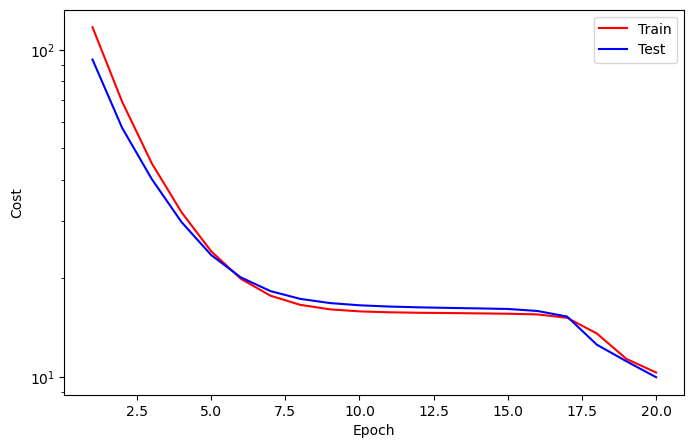

Train:   0%|          | 0/19 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch    21
Train_cost  = 9.5487 | Test_cost  = 9.1577 | 


Train:   0%|          | 0/19 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch    22
Train_cost  = 8.9696 | Test_cost  = 8.5473 | 


Train:   0%|          | 0/19 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch    23
Train_cost  = 8.5463 | Test_cost  = 8.0756 | 


Train:   0%|          | 0/19 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch    24
Train_cost  = 8.2133 | Test_cost  = 7.6975 | 


Train:   0%|          | 0/19 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch    25
Train_cost  = 7.9416 | Test_cost  = 7.3831 | 


Train:   0%|          | 0/19 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch    26
Train_cost  = 7.7180 | Test_cost  = 7.1171 | 


Train:   0%|          | 0/19 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch    27
Train_cost  = 7.5333 | Test_cost  = 6.8902 | 


Train:   0%|          | 0/19 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch    28
Train_cost  = 7.3794 | Test_cost  = 6.6959 | 


Train:   0%|          | 0/19 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch    29
Train_cost  = 7.2499 | Test_cost  = 6.5289 | 


Train:   0%|          | 0/19 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch    30
Train_cost  = 7.1402 | Test_cost  = 6.3849 | 


Train:   0%|          | 0/19 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch    31
Train_cost  = 7.0467 | Test_cost  = 6.2600 | 


Train:   0%|          | 0/19 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch    32
Train_cost  = 6.9666 | Test_cost  = 6.1514 | 


Train:   0%|          | 0/19 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch    33
Train_cost  = 6.8973 | Test_cost  = 6.0562 | 


Train:   0%|          | 0/19 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch    34
Train_cost  = 6.8369 | Test_cost  = 5.9724 | 


Train:   0%|          | 0/19 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch    35
Train_cost  = 6.7838 | Test_cost  = 5.8982 | 


Train:   0%|          | 0/19 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch    36
Train_cost  = 6.7365 | Test_cost  = 5.8321 | 


Train:   0%|          | 0/19 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch    37
Train_cost  = 6.6939 | Test_cost  = 5.7728 | 


Train:   0%|          | 0/19 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch    38
Train_cost  = 6.6551 | Test_cost  = 5.7194 | 


Train:   0%|          | 0/19 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch    39
Train_cost  = 6.6192 | Test_cost  = 5.6711 | 


Train:   0%|          | 0/19 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch    40
Train_cost  = 6.5858 | Test_cost  = 5.6270 | 


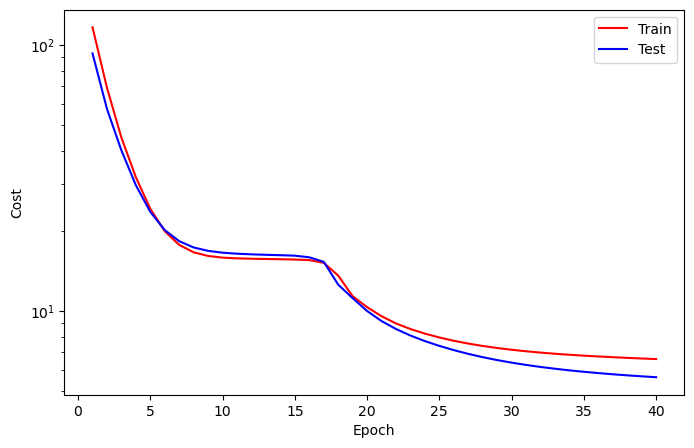

Train:   0%|          | 0/19 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch    41
Train_cost  = 6.5543 | Test_cost  = 5.5867 | 


Train:   0%|          | 0/19 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch    42
Train_cost  = 6.5246 | Test_cost  = 5.5496 | 


Train:   0%|          | 0/19 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch    43
Train_cost  = 6.4964 | Test_cost  = 5.5154 | 


Train:   0%|          | 0/19 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch    44
Train_cost  = 6.4696 | Test_cost  = 5.4837 | 


Train:   0%|          | 0/19 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch    45
Train_cost  = 6.4440 | Test_cost  = 5.4544 | 


Train:   0%|          | 0/19 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch    46
Train_cost  = 6.4195 | Test_cost  = 5.4271 | 


Train:   0%|          | 0/19 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch    47
Train_cost  = 6.3960 | Test_cost  = 5.4016 | 


Train:   0%|          | 0/19 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch    48
Train_cost  = 6.3734 | Test_cost  = 5.3779 | 


Train:   0%|          | 0/19 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch    49
Train_cost  = 6.3517 | Test_cost  = 5.3557 | 


Train:   0%|          | 0/19 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch    50
Train_cost  = 6.3309 | Test_cost  = 5.3350 | 


Train:   0%|          | 0/19 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch    51
Train_cost  = 6.3109 | Test_cost  = 5.3156 | 


Train:   0%|          | 0/19 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch    52
Train_cost  = 6.2919 | Test_cost  = 5.2976 | 


Train:   0%|          | 0/19 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch    53
Train_cost  = 6.2738 | Test_cost  = 5.2809 | 


Train:   0%|          | 0/19 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch    54
Train_cost  = 6.2567 | Test_cost  = 5.2656 | 


Train:   0%|          | 0/19 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch    55
Train_cost  = 6.2407 | Test_cost  = 5.2517 | 


Train:   0%|          | 0/19 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch    56
Train_cost  = 6.2256 | Test_cost  = 5.2390 | 


Train:   0%|          | 0/19 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch    57
Train_cost  = 6.2117 | Test_cost  = 5.2276 | 


Train:   0%|          | 0/19 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch    58
Train_cost  = 6.1988 | Test_cost  = 5.2175 | 


Train:   0%|          | 0/19 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch    59
Train_cost  = 6.1869 | Test_cost  = 5.2086 | 


Train:   0%|          | 0/19 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch    60
Train_cost  = 6.1760 | Test_cost  = 5.2008 | 


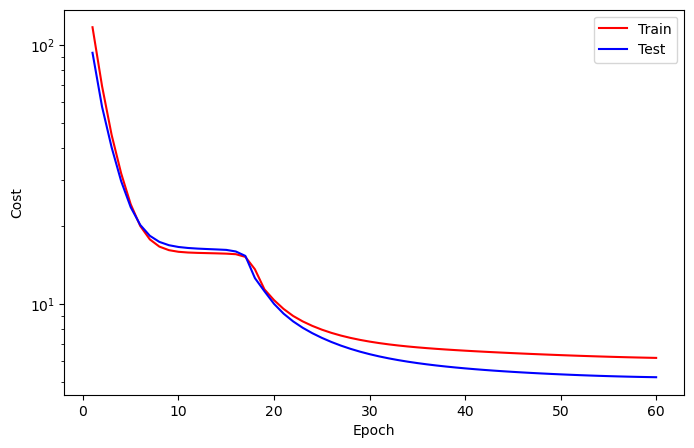

Train:   0%|          | 0/19 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch    61
Train_cost  = 6.1661 | Test_cost  = 5.1941 | 


Train:   0%|          | 0/19 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch    62
Train_cost  = 6.1569 | Test_cost  = 5.1885 | 


Train:   0%|          | 0/19 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch    63
Train_cost  = 6.1485 | Test_cost  = 5.1839 | 


Train:   0%|          | 0/19 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch    64
Train_cost  = 6.1406 | Test_cost  = 5.1802 | 


Train:   0%|          | 0/19 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch    65
Train_cost  = 6.1333 | Test_cost  = 5.1773 | 


Train:   0%|          | 0/19 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch    66
Train_cost  = 6.1263 | Test_cost  = 5.1753 | 


Train:   0%|          | 0/19 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch    67
Train_cost  = 6.1197 | Test_cost  = 5.1739 | 


Train:   0%|          | 0/19 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch    68
Train_cost  = 6.1132 | Test_cost  = 5.1731 | 


Train:   0%|          | 0/19 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch    69
Train_cost  = 6.1068 | Test_cost  = 5.1727 | 


Train:   0%|          | 0/19 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch    70
Train_cost  = 6.1005 | Test_cost  = 5.1727 | 


Train:   0%|          | 0/19 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch    71
Train_cost  = 6.0943 | Test_cost  = 5.1728 | 
==> EarlyStop patience =  1 | Best test_cost: 5.1727


Train:   0%|          | 0/19 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch    72
Train_cost  = 6.0881 | Test_cost  = 5.1730 | 
==> EarlyStop patience =  2 | Best test_cost: 5.1727


Train:   0%|          | 0/19 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch    73
Train_cost  = 6.0820 | Test_cost  = 5.1732 | 
==> EarlyStop patience =  3 | Best test_cost: 5.1727


Train:   0%|          | 0/19 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch    74
Train_cost  = 6.0759 | Test_cost  = 5.1734 | 
==> EarlyStop patience =  4 | Best test_cost: 5.1727


Train:   0%|          | 0/19 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch    75
Train_cost  = 6.0699 | Test_cost  = 5.1735 | 
==> EarlyStop patience =  5 | Best test_cost: 5.1727
==> Execute Early Stopping at epoch: 75 | Best test_cost: 5.1727
==> Best model is saved at model/multivar


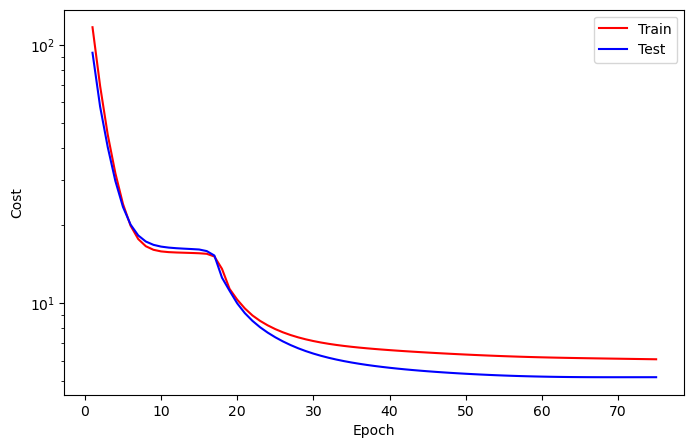

In [15]:
while True:
    train_cost = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break

# Forecast

In [16]:
from luwiji.rnn import illustration

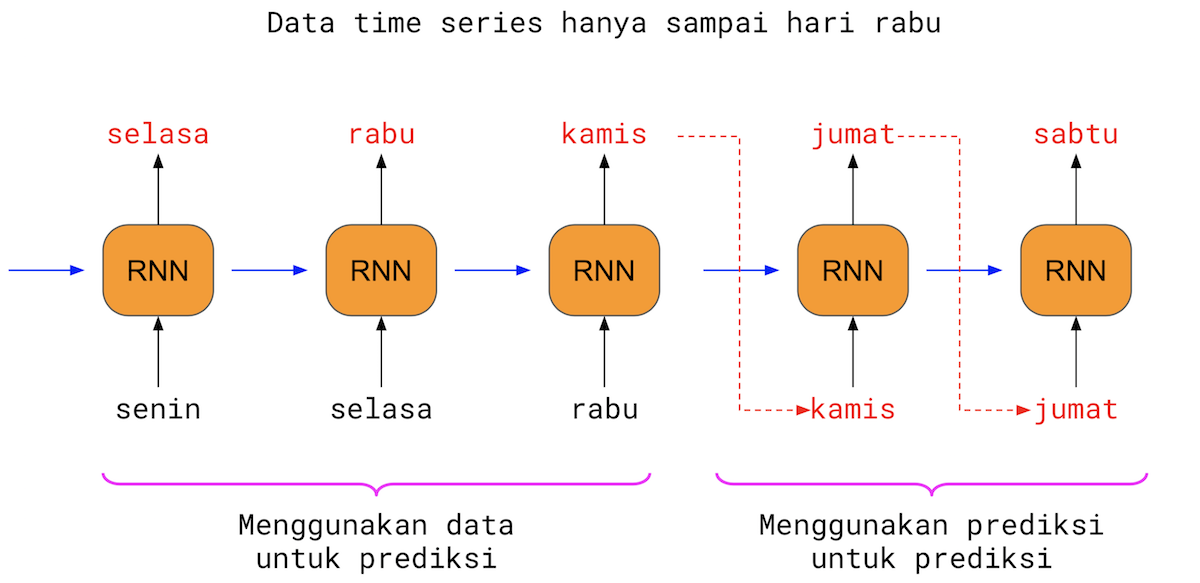

In [17]:
illustration.forecast

senin untuk prediksi hari selasa sebagai training,

selasa untuk prediksi hari rabu sebagai training,

rabu untuk prediksi hari kamis sebagai training,

kamis hasil prediksi digunakan untuk prediksi jumat dan seterusnya

yang kiri untuk training, yang kanan di pakai untuk prediksi masa depan

In [18]:
from utils import data4pred, pred4pred

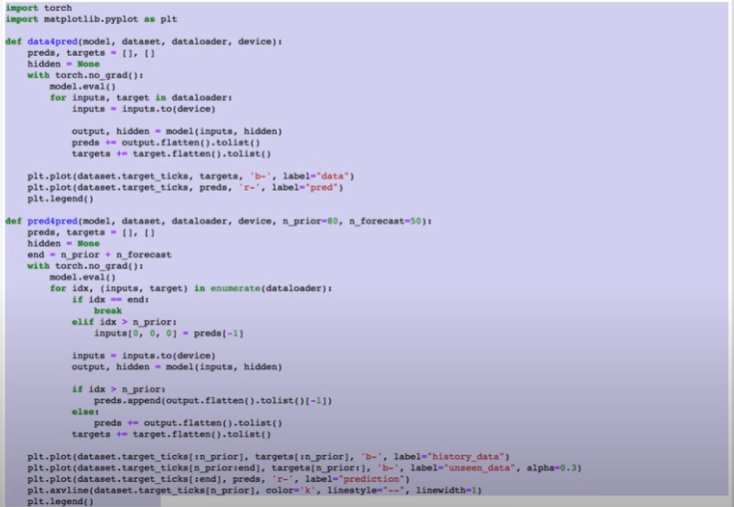

In [19]:
# import torch
# import matplotlib.pyplot as plt

# def data4pred(model, dataset, dataloader, device):
#     preds, targets = [], []
#     hidden = None
#     with torch.no_grad():
#         model.eval()
#         for inputs, target in dataloader:
#             inputs = inputs.to(device)
            
#             output, hidden = model(inputs, hidden)
#             preds += output.flatten().tolist()
#             targets += target.flatten().tolist()
    
#     plt.plot(dataset.target_ticks, targets, 'b-', label='data')
#     plt.plot(dataset.target_ticks, preds, 'r-', label='pred')
#     plt.legend()
    
# def pred4pred(model, dataset, dataloader, device, n_prior=80, n_forecast=50):
#     preds, targets = [], []
#     hidden = None
#     end = n_prior + n_forecast
#     with torch.no_grad():
#         model.eval()
#         for idx, (inputs, target) in enumerate(dataloader):
#             if idx == end:
#                 break
#             elif idx > n_prior:
#                 inputs[0, 0, 0] = preds[-1]
            
#             inputs = inputs.to(device)
#             output, hidden = model(inputs, hidden)
            
#             if idx > n_prior:
#                 preds.append(output.flatten().tolist()[-1])
#             else:
#                 preds += output.flatten().tolist()
#             targets += target.flatten().tolist()
            
#     plt.plot(dataset.target_ticks[:n_prior], targets[:n_prior], 'b-', label="history_data")
#     plt.plot(dataset.target_ticks[n_prior:end], targets[n_prior:], 'b-', label='unseen_data', alpha=0.3)
#     plt.plot(dataset.target_ticks[:end], preds, "r-", label="prediction")
#     plt.axvline(dataset.target_ticks[n_prior], color='k', linestyle='--', linewidth=1)
#     plt.legend()

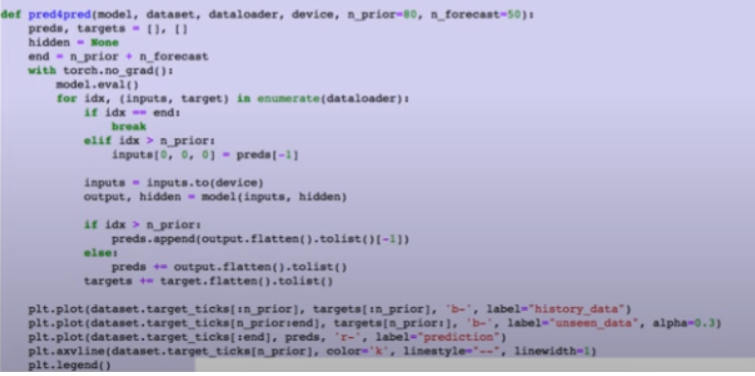

In [20]:
train_forecast_set = TimeSeriesDataset(ts_train, "Temp", 1)
trainforecastloader = DataLoader(train_forecast_set)

test_forecast_set = TimeSeriesDataset(ts_test, "Temp", 1)
testforecastloader = DataLoader(test_forecast_set)

(N, S, F): (2919, 1, 5)
Note: last 0 data excluded

(N, S, F): (729, 1, 5)
Note: last 0 data excluded



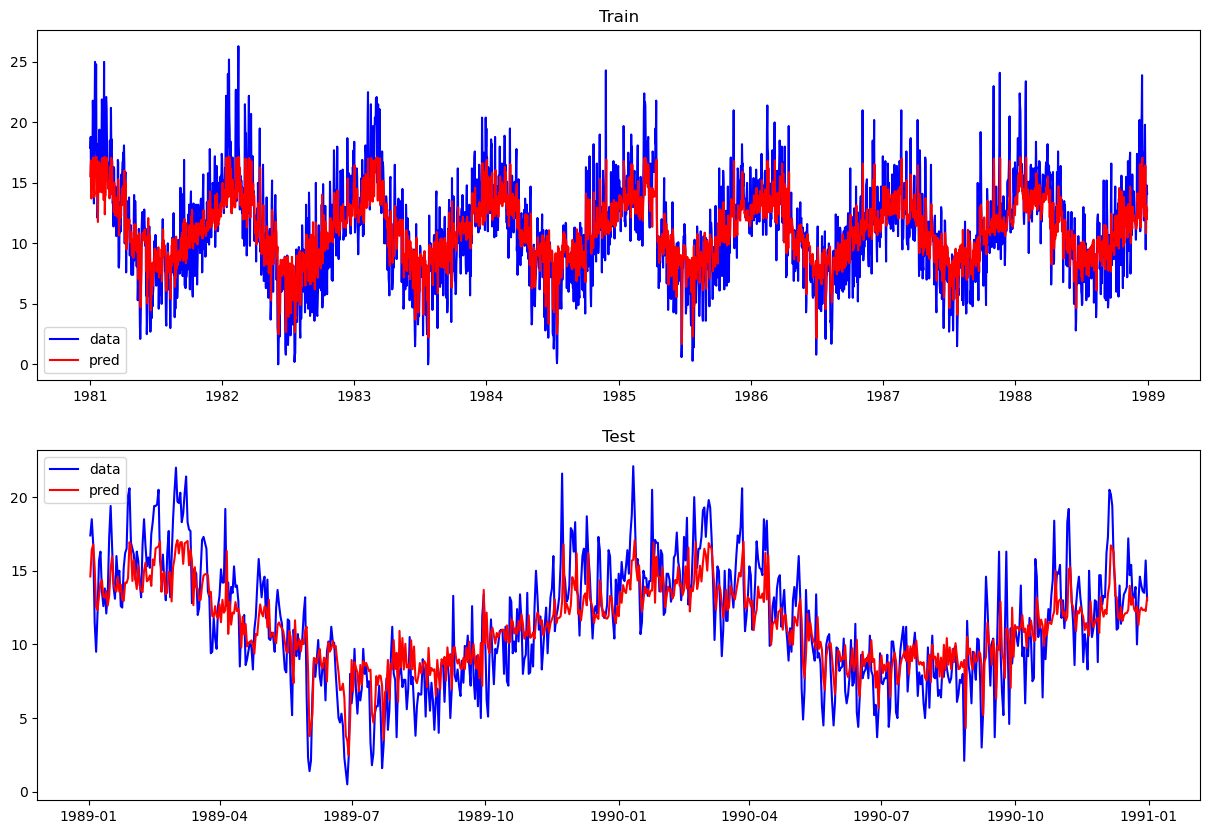

In [21]:
plt.figure(figsize=(15, 10))

plt.subplot(211)
data4pred(model, train_forecast_set, trainforecastloader, device)
plt.title("Train")

plt.subplot(212)
data4pred(model, test_forecast_set, testforecastloader, device)
plt.title("Test");

Text(0.5, 1.0, 'test')

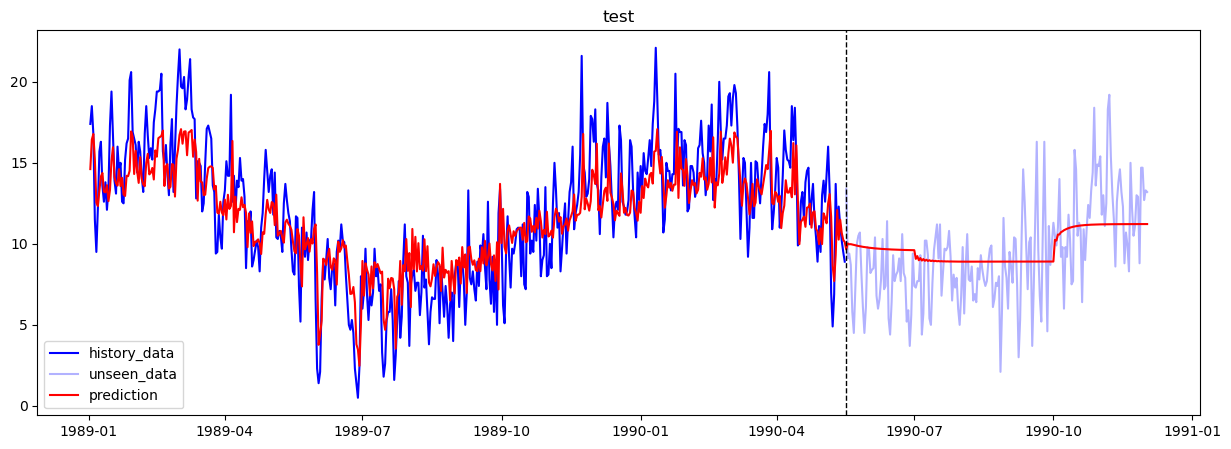

In [22]:
plt.figure(figsize=(15, 5))
pred4pred(model, test_forecast_set, testforecastloader, device)
plt.title("test")

note:

di time series forecasting by default itu overfit, kita harus expect prediksi kita salah. ketika data baru prediksi kita meleset

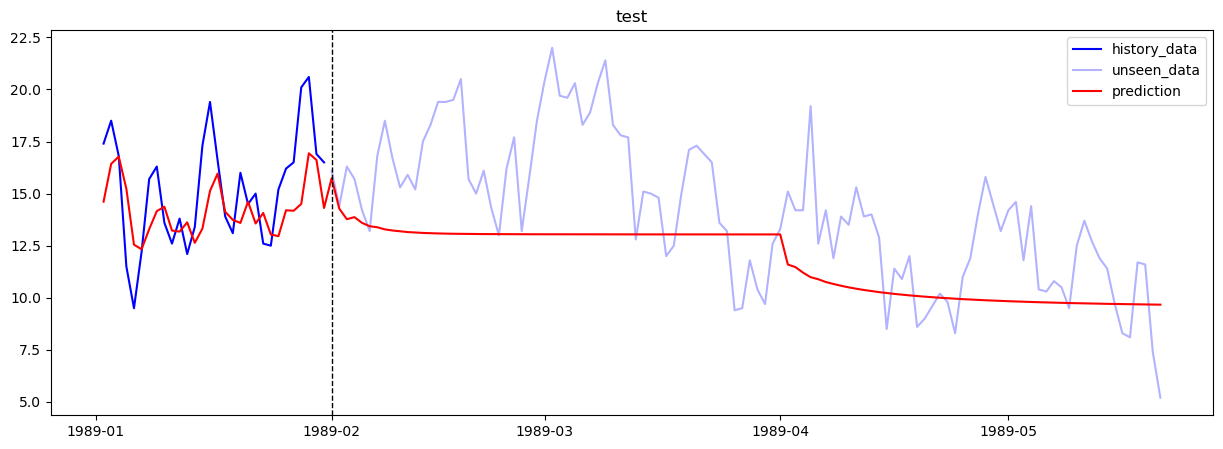

In [23]:
plt.figure(figsize=(15, 5))
pred4pred(model, test_forecast_set, testforecastloader, device, n_prior=30, n_forecast=110)
plt.title("test");

# More On RNN

In [1]:
from luwiji.rnn import illustration

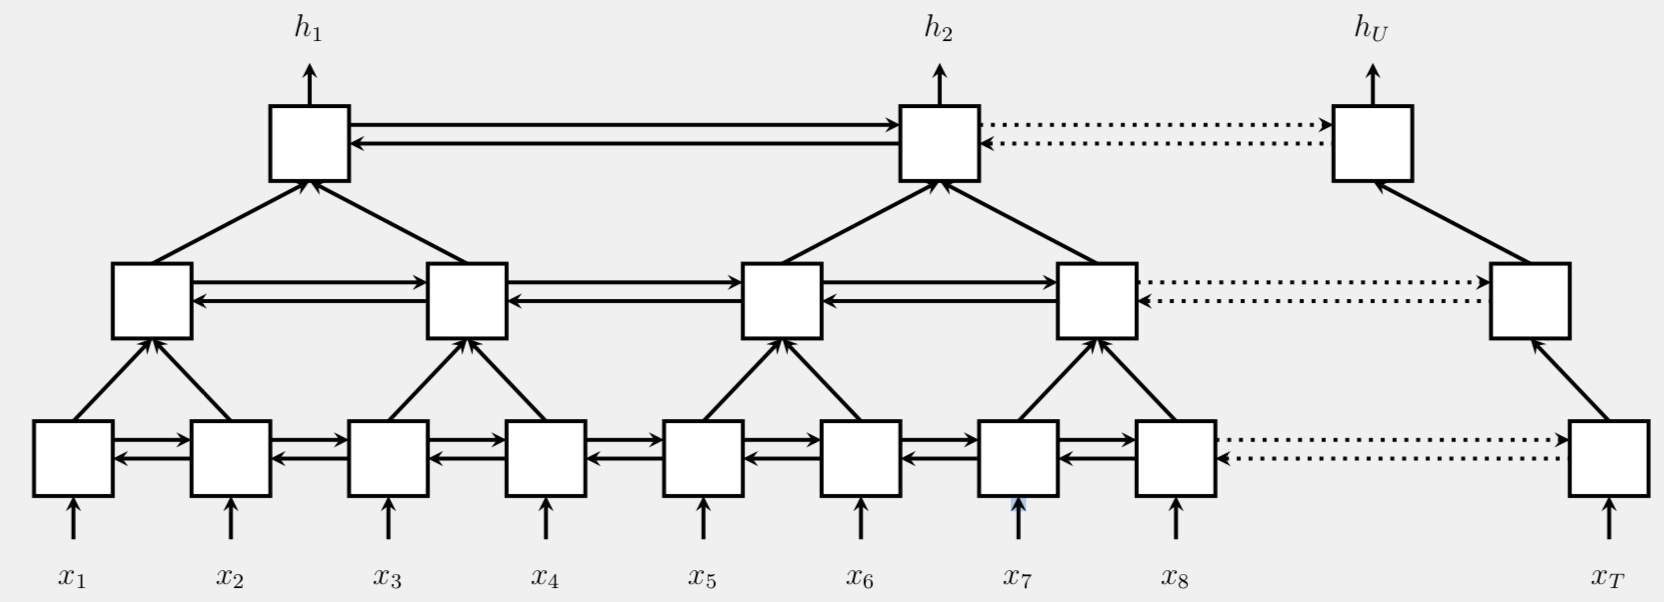

In [2]:
illustration.pyramid_blstm

* dipakai untuk speech technology

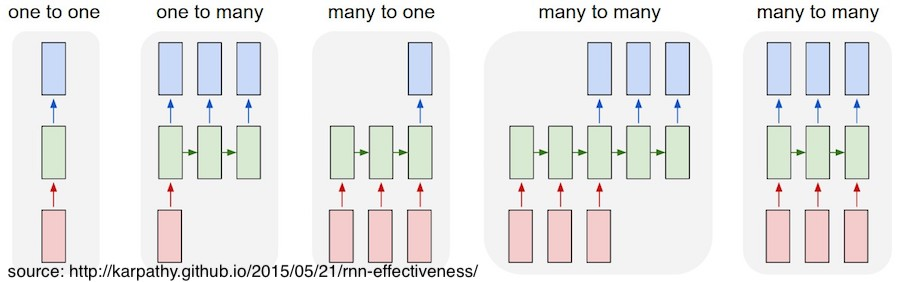

In [3]:
illustration.sequence_model

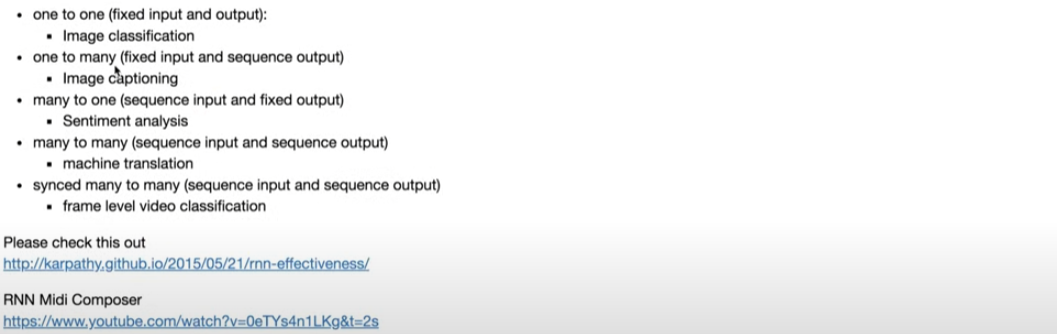

Tidak sepenuhnya benar. Istilah "multivariate" merujuk pada situasi atau analisis di mana terdapat lebih dari satu variabel yang sedang dipertimbangkan atau diamati secara bersamaan. Ini bisa berarti lebih dari satu fitur, tetapi juga bisa mencakup lebih dari satu variabel dalam konteks yang lebih luas, seperti dalam statistik atau analisis data.

Fitur adalah salah satu bentuk variabel dalam konteks data. Ketika Anda mengatakan "penambahan fitur," itu mungkin merujuk pada pengenalan variabel tambahan ke dalam suatu analisis atau model, misalnya dalam analisis data atau pembelajaran mesin. Namun, dalam bahasa sehari-hari, "fitur" biasanya terkait dengan karakteristik atau atribut yang dapat digunakan untuk menggambarkan atau membedakan entitas tertentu dalam suatu konteks.

Jadi, sementara multivariate analisis bisa melibatkan penambahan fitur, konsep "multivariate" tidak hanya terbatas pada fitur. Ini bisa mencakup berbagai jenis variabel seperti fitur, atribut, atau karakteristik lainnya yang diamati secara bersamaan dalam suatu analisis.